In [1]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import re
from sklearn.linear_model import LogisticRegression

### Sheet 10
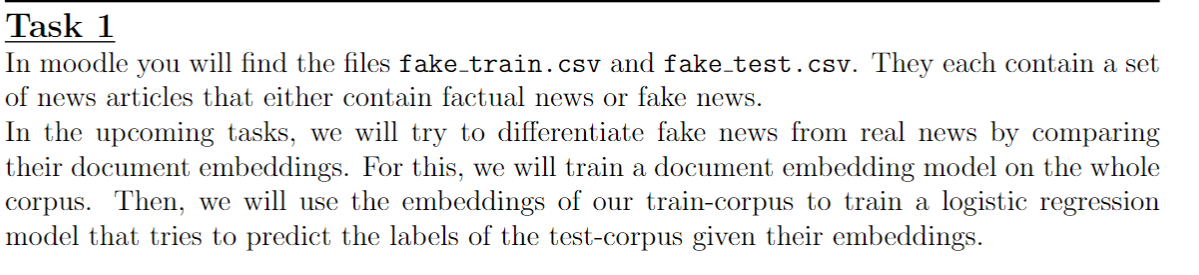

- This is kinda like a fine tuning exercise without the encoding layers and only with the embeddings

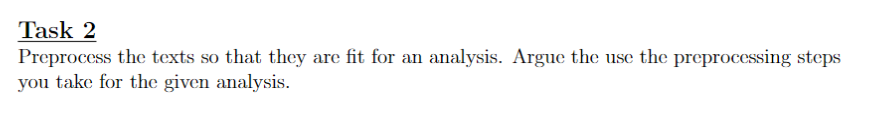

In [2]:
news_train = pd.read_csv("./data/fake_train.csv")
news_test = pd.read_csv("./data/fake_test.csv")
news_train.head()

,text,label
0,Trump administration to review goal of world w...,1
1,Turkish academics to be tried in April over Ku...,1
2,Factbox: Italy's new electoral law offers a mi...,1
3,WATCH: Trump Get His A** Handed To Him By Chr...,0
4,Mexico president says Trump visit could have b...,1


In [3]:
news_test.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


- I am guessing label is 1 for factual and 0 for fake news

In [9]:
print(news_train.text[2])

Factbox: Italy's new electoral law offers a mix of systems ROME (Reuters) - Italy s lower house of parliament on Thursday approved a new electoral law for use in the next national election, due by May 2018. The bill now passes to the upper house for further debate. Here are the main points of the bill. Italy gives Latin names to its electoral laws. This new proposal is called the Rosatellum, named after Ettore Rosato, the parliamentary party leader of the ruling Democratic Party (PD) who helped draft the legislation. The bill envisages that some 36 percent of parliamentarians in both the upper and lower houses will be elected on a first-past-the-post basis, with the rest chosen by pure proportional representation via party lists.  Parties can stand alone or as part of broader coalitions. Single parties need to win at least 3 percent of the vote to gain seats, while coalitions need to take 10 percent.  Unlike the previous Italian electoral law, the Rosatellum does not give an automatic 

I would suggest the following preprocessing:
- Being a bit more careful with special characters
  - removing '()-,!.":'
  - removing more than 1 whitespace
- Numbers are very important for retaining the information
  - Hence do not remove them
- Make lowercase
- Tokenize with whitespace afterwards

Otherwise use the `simple_preprocess` utility from `gensim` 

In [3]:
def preprocess(text):
  # remove special chars
  result = re.sub(r'[":()\[\]\-,!.]', "", text)
  
  # remove more than one whitespace
  result = re.sub("[ ]{2,}", " ", result).lower()
  result = result.split(" ")
  return result

In [4]:
# testing implementation
preprocess(news_train.text[0])

['trump',
 'administration',
 'to',
 'review',
 'goal',
 'of',
 'world',
 'without',
 'nuclear',
 'weapons',
 'aide',
 'washington',
 'reuters',
 'the',
 'trump',
 'administration',
 'is',
 'reviewing',
 'whether',
 'it',
 'will',
 'reaffirm',
 'the',
 'goal',
 'of',
 'a',
 'world',
 'without',
 'nuclear',
 'weapons',
 'a',
 'white',
 'house',
 'aide',
 'said',
 'on',
 'tuesday',
 'referring',
 'to',
 'an',
 'aim',
 'embraced',
 'by',
 'previous',
 'republican',
 'and',
 'democratic',
 'presidents',
 'and',
 'required',
 'by',
 'a',
 'key',
 'arms',
 'control',
 'treaty',
 'christopher',
 'ford',
 'the',
 'national',
 'security',
 'council’s',
 'senior',
 'director',
 'for',
 'weapons',
 'of',
 'mass',
 'destruction',
 'and',
 'counterproliferation',
 'said',
 'an',
 'examination',
 'of',
 'whether',
 'global',
 'nuclear',
 'disarmament',
 '“is',
 'a',
 'realistic',
 'goal”',
 'would',
 'be',
 'conducted',
 'as',
 'part',
 'of',
 'a',
 'wider',
 'assessment',
 'called',
 'the',
 'nucle

looking good, applying this to the data:

In [5]:
news_train["tokens"] = news_train.apply(lambda row: preprocess(row["text"]), axis=1)
news_train.head()

,text,label,tokens
0,Trump administration to review goal of world w...,1,"[trump, administration, to, review, goal, of, ..."
1,Turkish academics to be tried in April over Ku...,1,"[turkish, academics, to, be, tried, in, april,..."
2,Factbox: Italy's new electoral law offers a mi...,1,"[factbox, italy's, new, electoral, law, offers..."
3,WATCH: Trump Get His A** Handed To Him By Chr...,0,"[, watch, trump, get, his, a**, handed, to, hi..."
4,Mexico president says Trump visit could have b...,1,"[mexico, president, says, trump, visit, could,..."


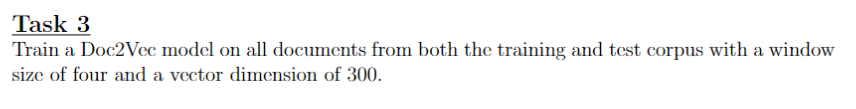


For this we need to preprocess the test data as well

In [6]:
news_test["tokens"] = news_test.apply(lambda row: preprocess(row["text"]), axis = 1)
news_test.head()

,text,label,tokens
0,"As U.S. budget fight looms, Republicans flip t...",1,"[as, us, budget, fight, looms, republicans, fl..."
1,U.S. military to accept transgender recruits o...,1,"[us, military, to, accept, transgender, recrui..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1,"[senior, us, republican, senator, 'let, mr, mu..."
3,FBI Russia probe helped by Australian diplomat...,1,"[fbi, russia, probe, helped, by, australian, d..."
4,Trump wants Postal Service to charge 'much mor...,1,"[trump, wants, postal, service, to, charge, 'm..."


In [7]:
train = pd.concat([news_test,news_train])

In [8]:
# following the online documentation of the module here:
# firstly setting up the training corpus
train_corpus = train.apply(lambda row: TaggedDocument(row["tokens"], row.index), axis=1).to_list()

# then instatiating the model
doc2vec = Doc2Vec(vector_size=300,
                  window=4)

# building a vocabulary
doc2vec.build_vocab(train_corpus)

# fitting the model
doc2vec.train(train_corpus, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

KeyboardInterrupt: 

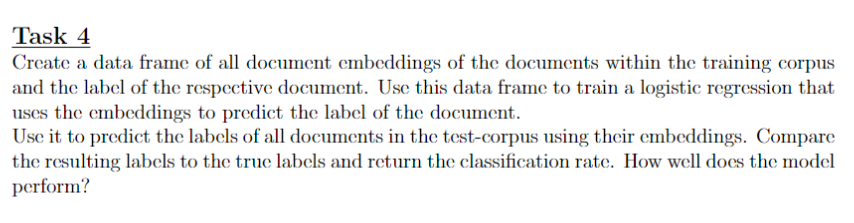

In [13]:
news_train["embedding"] = news_train.apply(lambda row: doc2vec.infer_vector(row["tokens"]), axis=1)

In [21]:
news_test["embedding"] = news_test.apply(lambda row: doc2vec.infer_vector(row["tokens"]), axis=1)

In [22]:
import numpy as np

X_train, y_train = np.array(news_train.embedding.to_list()), news_train.label
X_test, y_test = np.array(news_test.embedding.to_list()), news_test.label
# training the logistic regression
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
# scoring
lgr.score(X_test, y_test)

0.9507571334034023

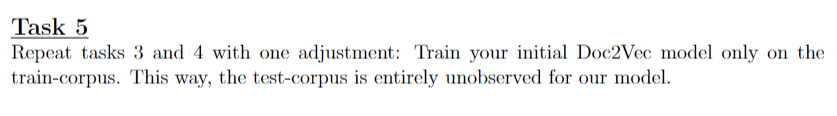

In [ ]:
# training only on the training set
train_corpus = news_train.apply(lambda row: TaggedDocument(row["tokens"], row.index), axis=1).to_list()

doc2vec_train = Doc2Vec(vector_size=300, window=4)
doc2vec_train.build_vocab(train_corpus)
doc2vec_train.train(train_corpus, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

In [ ]:
news_test["embedding"] = news_test.apply(lambda row: doc2vec_train.infer_vector(row["tokens"]), axis=1)
news_train["embedding"] = news_train.apply(lambda row: doc2vec.infer_vector(row["tokens"]), axis=1)

In [35]:
X_train, y_train = np.array(news_train.embedding.to_list()), news_train.label
X_test, y_test = np.array(news_test.embedding.to_list()), news_test.label

# training logistic regression
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
print("train:  %f" %(lgr.score(X_train, y_train)))
print("test: %f" %(lgr.score(X_test, y_test)))

train:  0.944939
test: 0.532368


O.o generalization is ass XD

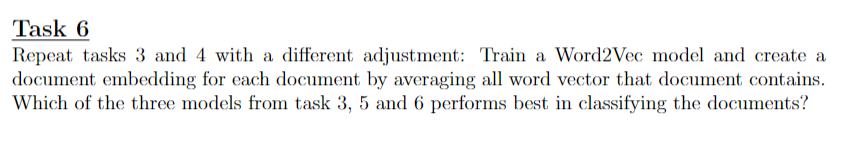

In [9]:
from gensim.models.word2vec import Word2Vec

w2v = Word2Vec(sentences=news_train.tokens.to_list(),
               vector_size=300,
               window=4,
               min_count=2,
               workers=6,
               epochs=40)

In [12]:
import numpy as np
def get_document_embedding(tokens):
  vecs = np.array([w2v.wv[token] for token in tokens])
  doc_emb = np.mean(vecs, axis= 0)
  return doc_emb